In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree, KNeighborsClassifier
import tracemalloc
import time
from collections import Counter

%matplotlib inline
# Retina 
%config InlineBackend.figure_format = 'retina'


In [2]:
def generate_random_dataset(N, D):
    np.random.seed(1265)
    return np.random.randn(N, D)

In [3]:
def naive_KNN(k, dataset, test_point):

  distances = list(enumerate(np.sqrt(np.sum((dataset - test_point)**2, axis=1))))
  sorted_distances = sorted(distances, key=lambda x: x[1])
  neighbors = [dataset[index] for (index, dist) in sorted_distances[:k]]

  return neighbors


def creating_bins(p, dataset):
    np.random.seed(1265)
    n, d = dataset.shape
    ones_mat = np.ones((n, 1))

    X = np.hstack([ones_mat, dataset])
    W = np.random.randn(d+1, p)

    H = X @ W > 0
    powers_of_two = (1 << np.arange(p-1, -1, -1))
    int_indices = H.dot(powers_of_two)

    hash_dict = {}
    for i in range(2**p):
        hash_dict[i] = []
    for i in range(n):
        index = int_indices[i]
        hash_dict[index].append(i)

    return W, hash_dict


def find_LSH_neighbors(dataset, test_point, p, k, W, hash_dict):
    n, d = dataset.shape
    ones = np.ones((n,1))
    X = np.hstack([ones, dataset])

    x = np.hstack([[1], test_point])
    h = x @ W > 0

    powers_of_two = (1 << np.arange(p-1, -1, -1))
    int_index = h.dot(powers_of_two)
    bucket_i = hash_dict[int_index]
    bucket = dataset[bucket_i]

    neighbors = naive_KNN(k, bucket, test_point)
    return neighbors

def make_prediction(dataset, labels, test_point, k, p, W, hash_dict):
    neighbors = find_LSH_neighbors(dataset, test_point, p, k, W, hash_dict)
    neighbor_indices = [
        np.where((dataset == neighbor).all(axis=1))[0][0] for neighbor in neighbors
    ]
    neighbor_labels = [labels[idx] for idx in neighbor_indices]
    most_common_label = Counter(neighbor_labels).most_common(1)[0][0]
    return most_common_label


In [4]:
# KD-tree KNN implementation
class KDTreeKNN:
    def __init__(self, train_data):
        self.tree = KDTree(train_data)

    def query(self, test_point, K):
        distances, indices = self.tree.query(test_point.reshape(1, -1), k=K)
        return indices

In [5]:
# Measure time taken for training and testing
def measure_time1(train_data, test_point, K):
    train_time = 0
    test_time = 0
    iter = 1000
    for _ in range(iter):
      start_time = time.time()

      neighbors = naive_KNN(K, train_data, test_point)

      end_time = time.time()

      test_time += (end_time- start_time)
    test_time /= iter
    train_time = 0

    return train_time, test_time


def measure_time2(train_data, test_point, K):
    train_time = 0
    test_time = 0
    iter=1000
    for _ in range(iter):
      start_time = time.time()

      W, hash_dict = creating_bins(3, train_data)
      ckpt_1 = time.time()

      lsh_neighbors = find_LSH_neighbors(train_data, test_point, 3, K, W, hash_dict)

      end_time = time.time()

      train_time += (ckpt_1- start_time)
      test_time += (end_time- ckpt_1)
    train_time/=iter
    test_time /= iter

    return train_time, test_time


def measure_time3(model, train_data, test_point, K):
    train_time = 0
    test_time = 0
    iter=1000
    for _ in range(iter):
      start_time = time.time()
      KDTreeKNN(train_data=train_data)

      ckpt_1 = time.time()

      model.query(test_point, K)

      end_time = time.time()

      train_time += (ckpt_1- start_time)
      test_time += (end_time- ckpt_1)
    train_time/=iter
    test_time /= iter

    return train_time, test_time

In [6]:
def memory_usage_knn(train_data, test_point, K):
    tracemalloc.start()
    neighbors = naive_KNN(K, train_data, test_point)
    mem = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return mem

def memory_usage_lsh(train_data, test_point, K):
    tracemalloc.start()
    W, hash_dict = creating_bins(3, train_data)
    lsh_neighbors = find_LSH_neighbors(train_data, test_point, 3, K, W, hash_dict)
    mem = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return mem

def memory_usage_kd(train_data, test_point, K):
    tracemalloc.start()
    model = KDTreeKNN(train_data=train_data)
    model.query(test_point, K)
    mem = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return mem

In [7]:
def visualize_missed_neighbors(dataset, true_nearest_points, found_nearest_points, test_point, K, title):
  plt.scatter(dataset[:, 0], dataset[:, 1], color='#629ccd', label='Dataset')
  plt.scatter(test_point[0], test_point[1], color='red', marker='x', label='Test Point')
  plt.scatter(true_nearest_points[:, 0], true_nearest_points[:, 1], color='orange', label='True Nearest Neighbors')
  plt.scatter(found_nearest_points[:, 0], found_nearest_points[:, 1], color='green', marker = "*", label='Found Nearest Neighbors')
  plt.title(title)
  plt.legend()
  plt.show()

def plot_knn(dataset, test_point, neighbors):
  plt.scatter(dataset[:, 0], dataset[:, 1], label='Data points', color='#629ccd')
  plt.scatter(test_point[0], test_point[1], label='Test point', c='red')
  plt.scatter(neighbors[:, 0], neighbors[:, 1], label='k nearest neighbors', c='yellow')
  plt.title("K Nearest Neighbors")
  plt.legend()
  plt.show()

def plot_lsh(W, dataset, test_point, true_nearest_points, lsh_neighbors):
  plt.scatter(dataset[:, 0], dataset[:, 1], label='Data points', )
  plt.scatter(test_point[0], test_point[1], label='Test point', c='red')
  plt.scatter(true_nearest_points[:, 0], true_nearest_points[:, 1], color='orange', label='True Nearest Neighbors')
  plt.scatter(lsh_neighbors[:, 0], lsh_neighbors[:, 1], label='LSH neighbors', c='green')

  for i in range(W.shape[1]):
    #plt.plot(np.arange(min(dataset[:, 0]), max(dataset[:, 0]), 0.1), W[:, i][0]+W[:, i][1]*np.arange(min(dataset[:, 0]), max(dataset[:, 0]), 0.1)+W[:, i][2]*np.arange(min(dataset[:, 0]), max(dataset[:, 0]), 0.1), linestyle='--', c='black')
    x1 = np.array([min(dataset[:, 0]), max(dataset[:, 0])])
    x2 = (-W[0, i] - W[1, i]*x1) / W[2, i]
    plt.plot(x1, x2, label=f'Hyperplane {i+1}')

  #plt.plot(np.arange(min(dataset[:, 0]), max(dataset[:, 0]), 0.1), W[:, W.shape[1]-1][0]+W[:, W.shape[1]-1][1]*np.arange(min(dataset[:, 0]), max(dataset[:, 0]), 0.1)+W[:, W.shape[1]-1][2]*np.arange(min(dataset[:, 0]), max(dataset[:, 0]), 0.1), linestyle='--', c='black', label='Partitions')
  plt.ylim(top=2.5, bottom=-2.5)
  plt.title('LSH Partitions')
  plt.legend()
  plt.show()

In [8]:
N_values = [100, 1000]
D_values = [2, 1000]
K = 3

for N in N_values:
    for D in D_values:
        print("*********************************************************")
        print(f"Dataset Size: {N}, Dimensions: {D}")
        # Generate dataset
        dataset = generate_random_dataset(N, D)

        # Generate test data
        test_data = np.random.randn(D)
    
        # Naive KNN
        neighbors_naive = naive_KNN(K, dataset, test_data)
        neighbors = np.array([list(neighbors_naive[0]), list(neighbors_naive[1]), list(neighbors_naive[2])])
        naive_training_time, naive_testing_time = measure_time1(dataset, test_data, K)

        # LSH KNN
        p = 10
        W, hash_dict = creating_bins(p, dataset)
        neighbors_lsh = find_LSH_neighbors(dataset, test_data, p, K, W, hash_dict)
        #lsh_neighbors = np.array([list(neighbors_lsh[0]), list(neighbors_lsh[1]), list(neighbors_lsh[2])])
        lsh_training_time, lsh_testing_time = measure_time2(dataset, test_data, K)

        # KD-tree KNN
        kdtree_model = KDTreeKNN(train_data=dataset)
        kdtree_training_time, kdtree_testing_time = measure_time3(kdtree_model, dataset, test_data, K)

        # Print table headers
        print(f"{'Model':<30}{'Training Time':<30}{'Testing Time'}")

        # Print rows with appropriate formatting
        print(f"{'Naive KNN:':<30}{naive_training_time:<30}{naive_testing_time}")
        print(f"{'LSH KNN:':<30}{lsh_training_time:<30}{lsh_testing_time}")
        print(f"{'KD-tree KNN:':<30}{kdtree_training_time:<30}{kdtree_testing_time}")


        naive_memory_usage = memory_usage_knn(dataset, test_data, K)
        lsh_memory_usage = memory_usage_lsh(dataset, test_data, K)
        kdtree_memory_usage = memory_usage_kd(dataset, test_data, K)

        print("\nNaive KNN Memory Usage:", naive_memory_usage, "bytes")
        print("LSH KNN Memory Usage:", lsh_memory_usage, "bytes")
        print("KD-tree KNN Memory Usage:", kdtree_memory_usage, "bytes\n")


*********************************************************
Dataset Size: 100, Dimensions: 2
Model                         Training Time                 Testing Time
Naive KNN:                    0                             2.2883892059326172e-05
LSH KNN:                      2.7247905731201172e-05        3.2059192657470705e-05
KD-tree KNN:                  3.623151779174805e-05         3.0415534973144532e-05

Naive KNN Memory Usage: (376, 5032) bytes
LSH KNN Memory Usage: (2968, 12732) bytes
KD-tree KNN Memory Usage: (5392, 7576) bytes

*********************************************************
Dataset Size: 100, Dimensions: 1000
Model                         Training Time                 Testing Time
Naive KNN:                    0                             8.340859413146973e-05
LSH KNN:                      0.00010375118255615234        4.5180320739746094e-05
KD-tree KNN:                  0.0001627073287963867         0.00011774373054504395

Naive KNN Memory Usage: (847, 867839) by

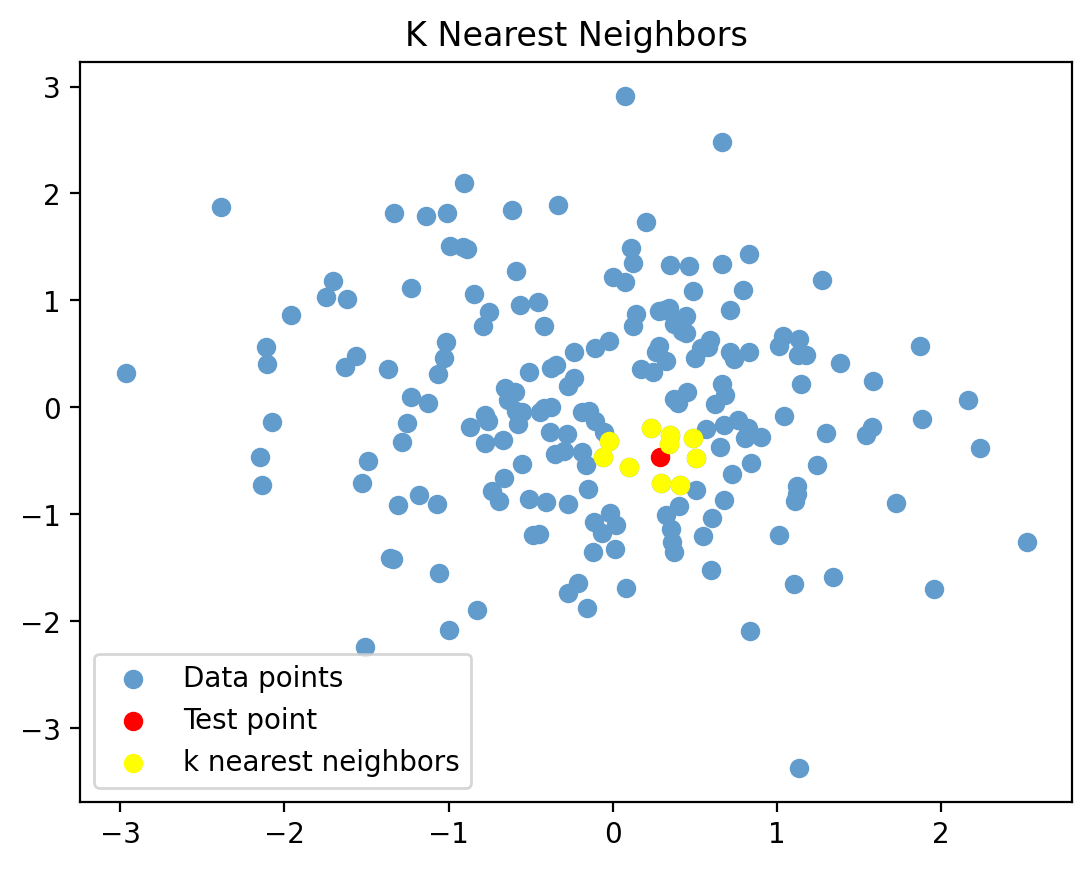

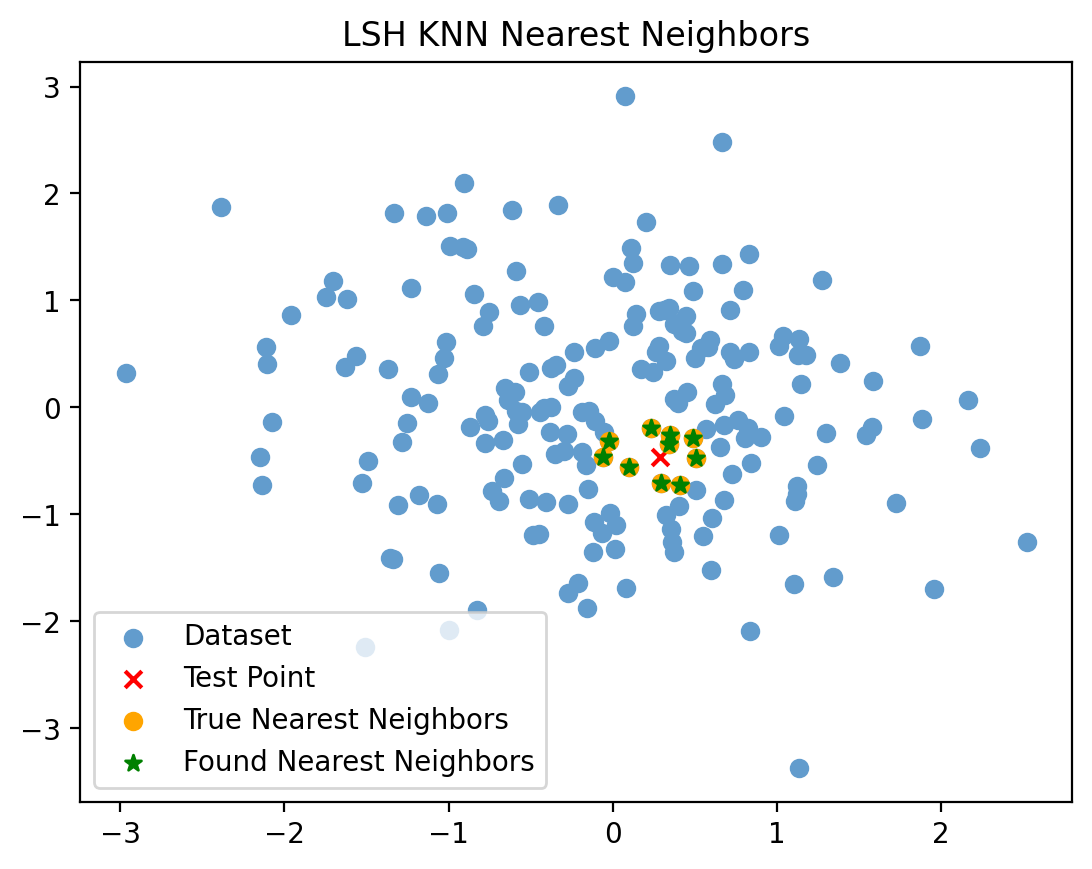

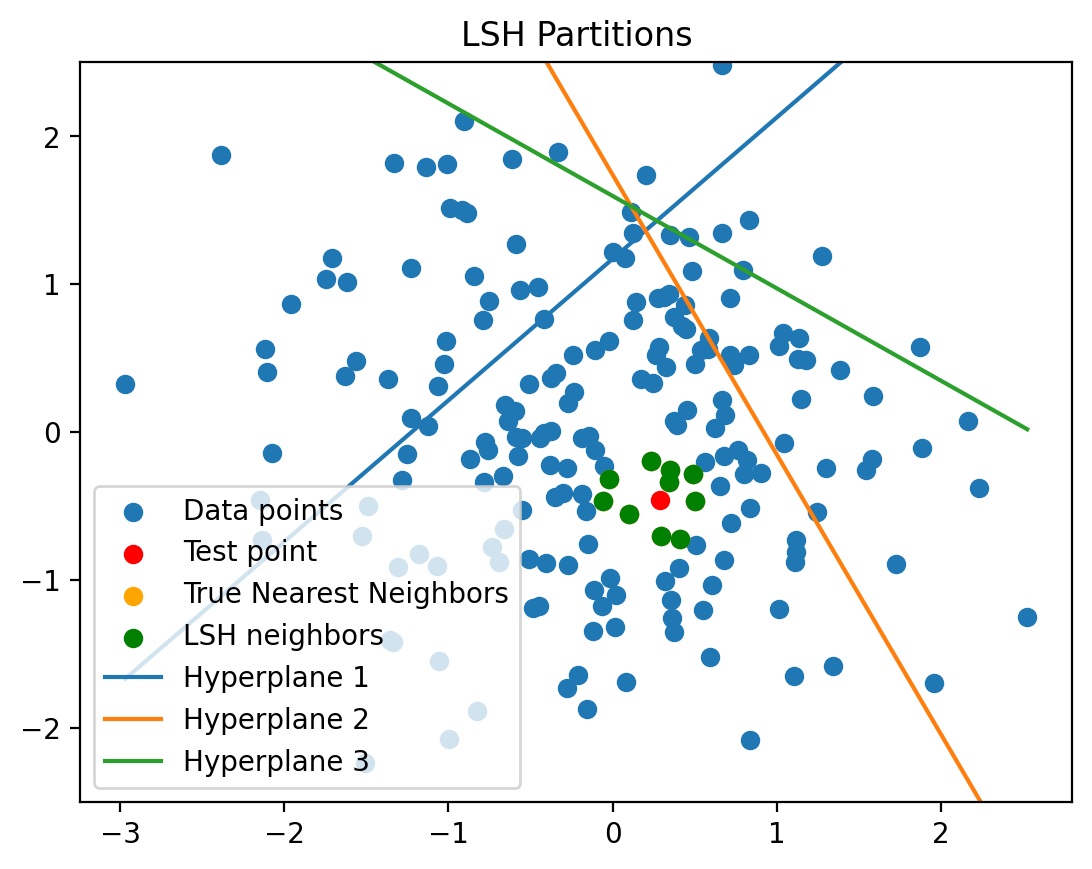

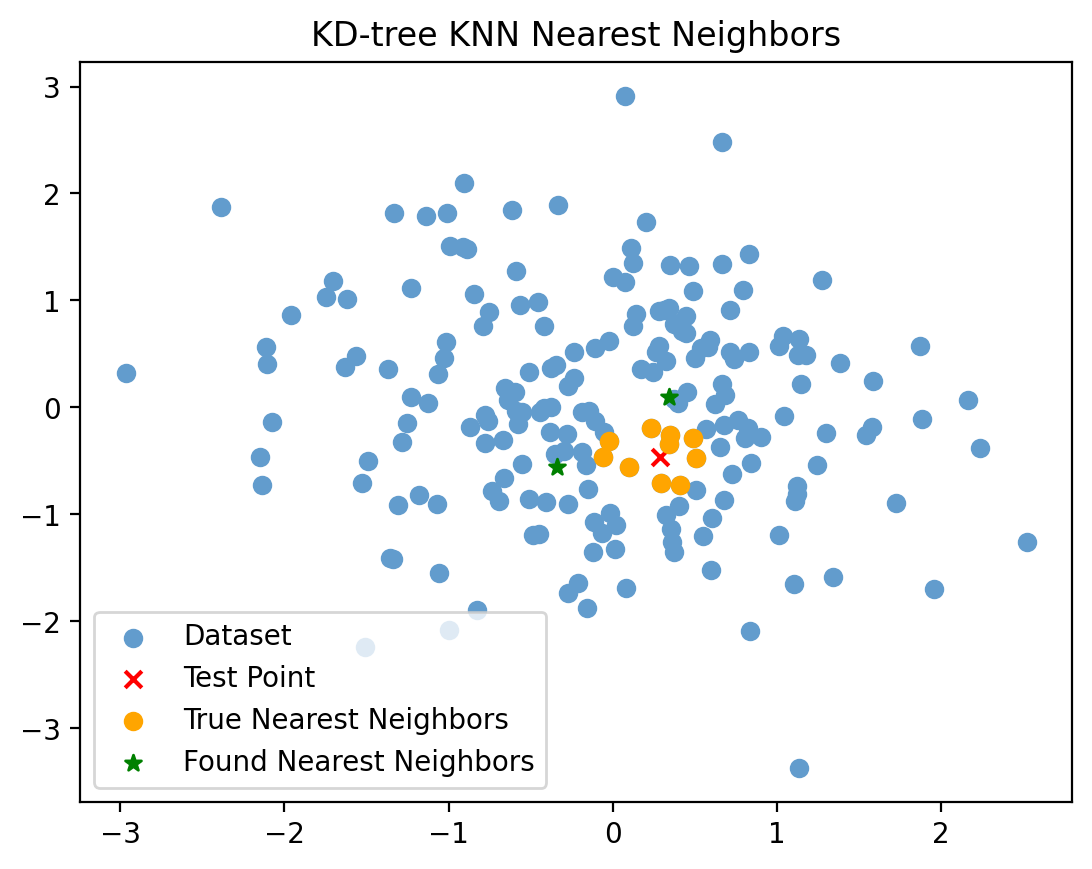

In [9]:
N, D, K = 200, 2, 10
dataset = generate_random_dataset(N, D)

# Generate test data
np.random.seed(124)
test_data = np.random.randn(D)

# Naive KNN
neighbors_naive = naive_KNN(K, dataset, test_data)
neighbors = np.array(list(neighbors_naive[i] for i in range(K)))

plot_knn(dataset, test_data, neighbors)

# LSH KNN
p = 3
W, hash_dict = creating_bins(p, dataset)
neighbors_lsh = find_LSH_neighbors(dataset, test_data, p, K, W, hash_dict)
min_ = min(K, len(neighbors_lsh))
lsh_neighbors = np.array([neighbors_lsh[i] for i in range(min_)])
visualize_missed_neighbors(dataset, neighbors, lsh_neighbors, test_data, K, 'LSH KNN Nearest Neighbors')
plot_lsh(W, dataset, test_data, neighbors, lsh_neighbors)

# KD-tree KNN
kdtree_model = KDTreeKNN(train_data=dataset)
kdtree_nearest_indices = kdtree_model.query(test_data, K)
kdtree_nearest_neighbors = dataset[kdtree_nearest_indices]
visualize_missed_neighbors(dataset, neighbors, kdtree_nearest_neighbors, test_data, K, 'KD-tree KNN Nearest Neighbors')

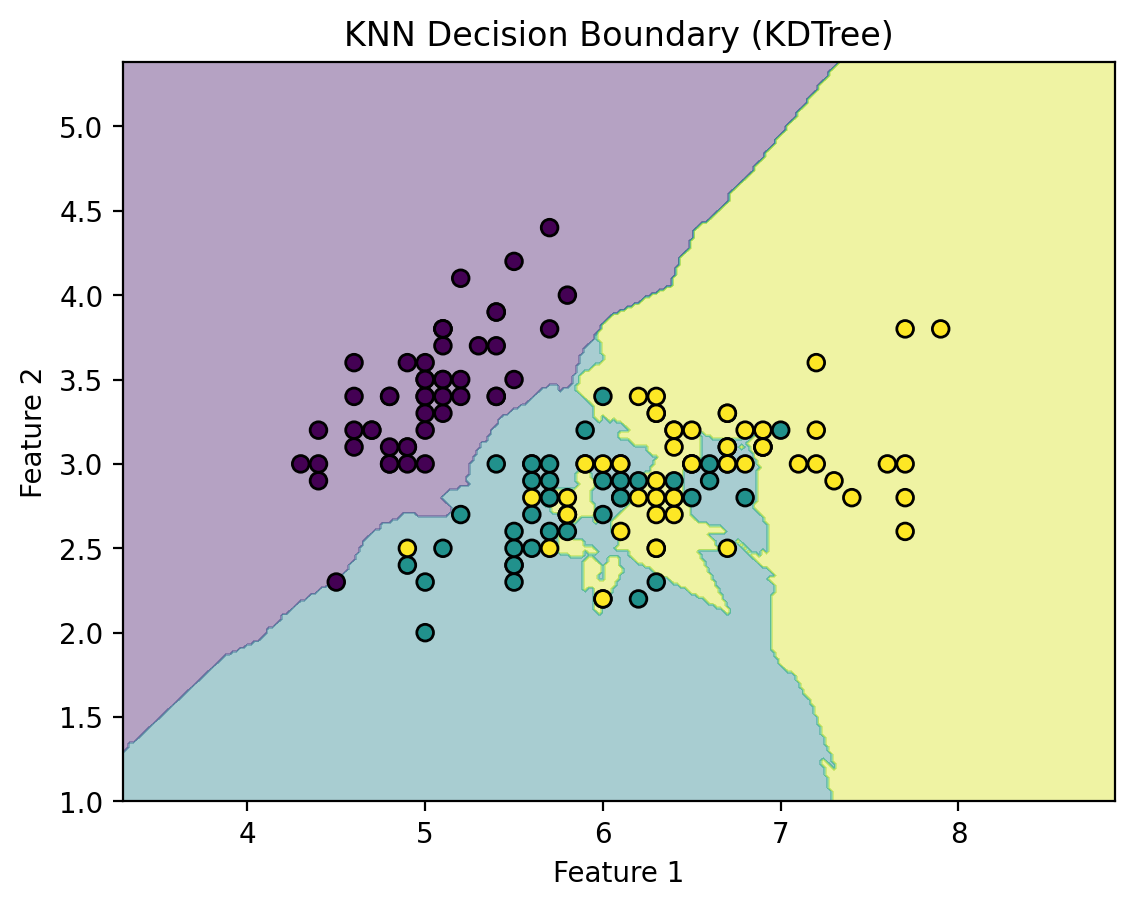

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

iris = load_iris()
X = iris.data[:, :2]
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree', leaf_size=3)
knn.fit(X_train, y_train)

def plot_decision_boundary(model, X, y):
    # Define grid range
    h = 0.02  # Step size
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict for the entire grid
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid_points)
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.viridis)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.viridis)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('KNN Decision Boundary (KDTree)')
    plt.show()

# Plot the decision boundary
plot_decision_boundary(knn, X, y)


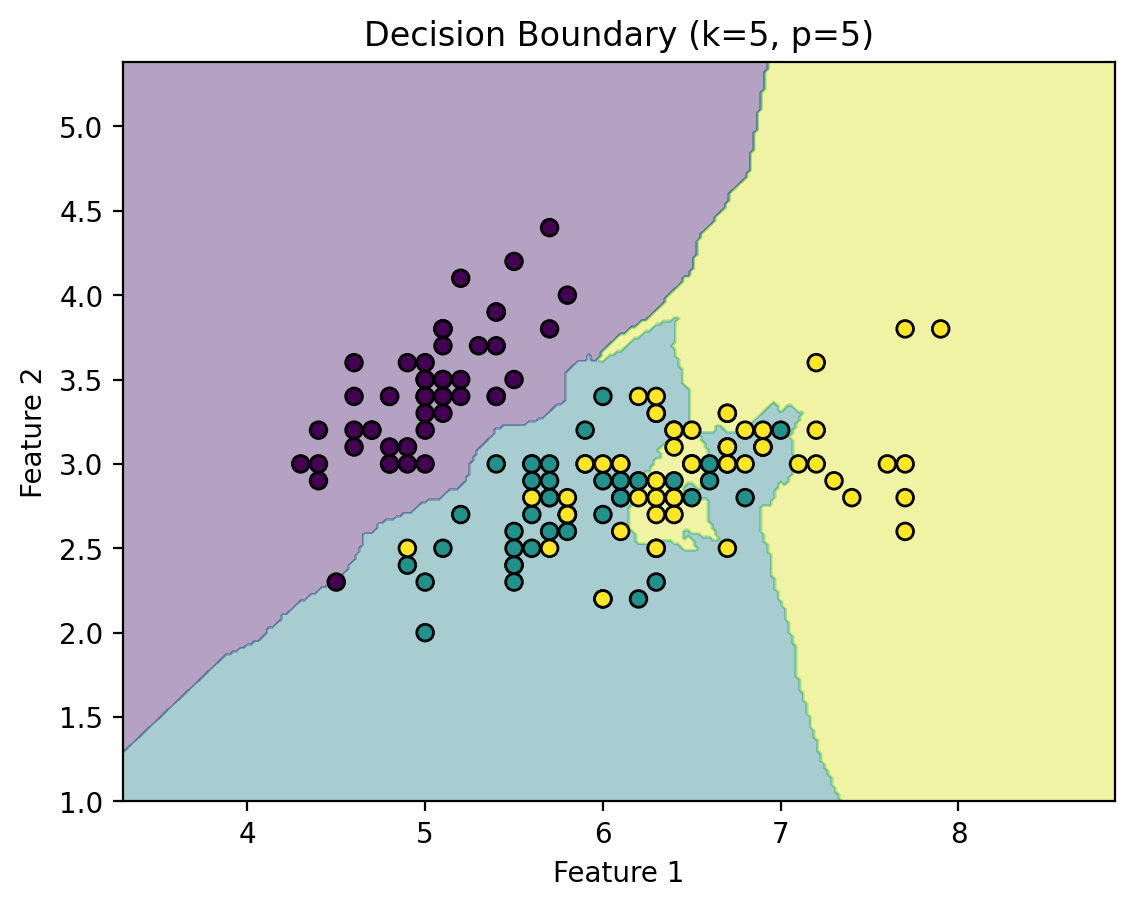

In [11]:
def plot_decision_boundary(dataset, labels, k, p, W, hash_dict):
    h = 0.02  # Grid step size
    x_min, x_max = dataset[:, 0].min() - 1, dataset[:, 0].max() + 1
    y_min, y_max = dataset[:, 1].min() - 1, dataset[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Z = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            test_point = np.array([xx[i, j], yy[i,j]])
            Z[i, j] = make_prediction(dataset, labels, test_point, k, p, W, hash_dict)
    
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.viridis)
    plt.scatter(dataset[:, 0], dataset[:, 1], c=labels, cmap=plt.cm.viridis, edgecolor='k')
    plt.title(f'Decision Boundary (k={k}, p={p})')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

iris = load_iris()
X = iris.data[:, :2]
y = iris.target

p = 5
W, hash_dict = creating_bins(p, X)

k = 5
plot_decision_boundary(X, y, k, p, W, hash_dict)